In [2]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import pandas_profiling
import numpy as np
import re
import requests
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


import warnings
import types

%load_ext autoreload
%autoreload 2
 
%matplotlib inline

In [3]:
acsg = pd.read_csv('ACS_Merge_Norm_Final.csv', index_col=0) 
acsg.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,Pop16yrsOver,Labor_forceN,CivilianLF,CLF_UnemployedN,PopOver25,EduOtherN,EduBachelor,EduGradProf,GardenCounts,HasGarden
0,NTA2010,Bath Beach,BK27,Brooklyn,33163.0,0.503151,0.496849,0.214184,0.147393,0.176733,...,26855.0,0.596016,15985.0,0.070566,23822.0,0.663798,0.224372,0.111829,0.0,0.0
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134.0,0.478037,0.521963,0.190942,0.156444,0.178608,...,65479.0,0.644115,42057.0,0.074922,58178.0,0.535735,0.271976,0.192289,0.0,0.0
2,NTA2010,Bedford,BK75,Brooklyn,75318.0,0.484492,0.515508,0.297127,0.077219,0.194933,...,54904.0,0.673776,36960.0,0.125027,44766.0,0.678193,0.204352,0.117455,23.0,1.0
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267.0,0.486766,0.513234,0.198749,0.157266,0.123283,...,52857.0,0.605483,31983.0,0.085202,46010.0,0.698153,0.204564,0.097283,1.0,1.0
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646.0,0.487212,0.512788,0.210462,0.142625,0.145975,...,74470.0,0.615577,45833.0,0.088342,65016.0,0.737618,0.188800,0.073582,2.0,1.0


In [9]:
#created feature to represent race 'other'
acsg['RaceOther'] = acsg.OtherRace1N + acsg.OtherRace2N + acsg.NativeN + acsg.PacificN

In [11]:
acsg.columns

Index(['GeoType', 'NTA', 'GeoID', 'Borough', 'Pop_1E', 'MaleEN', 'FemEN',
       'PopUnd18N', 'PopOv65N', 'HispN', 'NotHispN', 'WhiteN', 'BlackN',
       'NativeN', 'AsianN', 'PacificN', 'OtherRace1N', 'OtherRace2N', 'HHPop',
       'HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN', 'Pop16yrsOver', 'Labor_forceN',
       'CivilianLF', 'CLF_UnemployedN', 'PopOver25', 'EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts', 'HasGarden', 'RaceOther'],
      dtype='object')

In [86]:
#create new Df with features to use for PCA / analysis
#Garden counts = actual values (not normalized)

acsg1 = acsg[['NTA', 'FemEN',
       'PopOv65N', 'HispN','WhiteN', 'BlackN','AsianN','RaceOther','HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN','CLF_UnemployedN','EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts']].copy()

In [87]:
acsg1.head()

,NTA,FemEN,PopOv65N,HispN,WhiteN,BlackN,AsianN,RaceOther,HHINC_U10N,HHINC_10t14N,...,HHINC_50t74N,HHINC_75t99N,HHINC_100t149N,HHINC_150t199N,HHINC_200plN,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenCounts
0,Bath Beach,0.496849,0.147393,0.176733,0.436933,0.012182,0.361095,0.013057,0.078316,0.054078,...,0.181484,0.118306,0.153833,0.061778,0.051190,0.070566,0.663798,0.224372,0.111829,0.0
1,Bay Ridge,0.521963,0.156444,0.178608,0.634329,0.019094,0.145513,0.022456,0.069072,0.046973,...,0.166333,0.122674,0.144145,0.074566,0.082868,0.074922,0.535735,0.271976,0.192289,0.0
2,Bedford,0.515508,0.077219,0.194933,0.350607,0.405826,0.030404,0.018229,0.140949,0.088914,...,0.142216,0.087072,0.109252,0.045857,0.039679,0.125027,0.678193,0.204352,0.117455,23.0
3,Bensonhurst East,0.513234,0.157266,0.123283,0.465153,0.008262,0.386793,0.016509,0.106188,0.063686,...,0.175688,0.115293,0.108893,0.051562,0.038040,0.085202,0.698153,0.204564,0.097283,1.0
4,Bensonhurst West,0.512788,0.142625,0.145975,0.426773,0.008740,0.405168,0.013345,0.077903,0.058377,...,0.171086,0.114614,0.125146,0.055134,0.041158,0.088342,0.737618,0.188800,0.073582,2.0


In [88]:
acsg1.shape

(195, 23)

In [15]:
pandas_profiling.ProfileReport(acsg1)

In [89]:

acsg1.head()

,NTA,FemEN,PopOv65N,HispN,WhiteN,BlackN,AsianN,RaceOther,HHINC_U10N,HHINC_10t14N,...,HHINC_50t74N,HHINC_75t99N,HHINC_100t149N,HHINC_150t199N,HHINC_200plN,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenCounts
0,Bath Beach,0.496849,0.147393,0.176733,0.436933,0.012182,0.361095,0.013057,0.078316,0.054078,...,0.181484,0.118306,0.153833,0.061778,0.051190,0.070566,0.663798,0.224372,0.111829,0.0
1,Bay Ridge,0.521963,0.156444,0.178608,0.634329,0.019094,0.145513,0.022456,0.069072,0.046973,...,0.166333,0.122674,0.144145,0.074566,0.082868,0.074922,0.535735,0.271976,0.192289,0.0
2,Bedford,0.515508,0.077219,0.194933,0.350607,0.405826,0.030404,0.018229,0.140949,0.088914,...,0.142216,0.087072,0.109252,0.045857,0.039679,0.125027,0.678193,0.204352,0.117455,23.0
3,Bensonhurst East,0.513234,0.157266,0.123283,0.465153,0.008262,0.386793,0.016509,0.106188,0.063686,...,0.175688,0.115293,0.108893,0.051562,0.038040,0.085202,0.698153,0.204564,0.097283,1.0
4,Bensonhurst West,0.512788,0.142625,0.145975,0.426773,0.008740,0.405168,0.013345,0.077903,0.058377,...,0.171086,0.114614,0.125146,0.055134,0.041158,0.088342,0.737618,0.188800,0.073582,2.0


In [90]:
acsg1 = acsg1.set_index('NTA')

In [91]:
acsg1.head()

,FemEN,PopOv65N,HispN,WhiteN,BlackN,AsianN,RaceOther,HHINC_U10N,HHINC_10t14N,HHINC_15t24N,...,HHINC_50t74N,HHINC_75t99N,HHINC_100t149N,HHINC_150t199N,HHINC_200plN,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenCounts
NTA,,,,,,,,,,,,,,,,,,,,,
Bath Beach,0.496849,0.147393,0.176733,0.436933,0.012182,0.361095,0.013057,0.078316,0.054078,0.107018,...,0.181484,0.118306,0.153833,0.061778,0.051190,0.070566,0.663798,0.224372,0.111829,0.0
Bay Ridge,0.521963,0.156444,0.178608,0.634329,0.019094,0.145513,0.022456,0.069072,0.046973,0.096605,...,0.166333,0.122674,0.144145,0.074566,0.082868,0.074922,0.535735,0.271976,0.192289,0.0
Bedford,0.515508,0.077219,0.194933,0.350607,0.405826,0.030404,0.018229,0.140949,0.088914,0.129898,...,0.142216,0.087072,0.109252,0.045857,0.039679,0.125027,0.678193,0.204352,0.117455,23.0
Bensonhurst East,0.513234,0.157266,0.123283,0.465153,0.008262,0.386793,0.016509,0.106188,0.063686,0.122504,...,0.175688,0.115293,0.108893,0.051562,0.038040,0.085202,0.698153,0.204564,0.097283,1.0
Bensonhurst West,0.512788,0.142625,0.145975,0.426773,0.008740,0.405168,0.013345,0.077903,0.058377,0.113110,...,0.171086,0.114614,0.125146,0.055134,0.041158,0.088342,0.737618,0.188800,0.073582,2.0


In [66]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [93]:
acsg1 = acsg1.replace([np.inf, -np.inf, np.nan], 0)


### Update: Dec 11 PM

In [103]:
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(acsg1)

([<matplotlib.axis.XTick at 0x1a24a6aac8>,
 <a list of 10 Text xticklabel objects>)

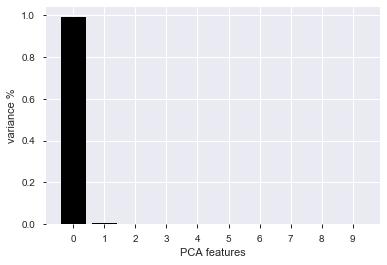

In [104]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [105]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Fig. 1 shows that the first three components explain the majority of the variance in our data. For this visualization use case, we will quickly plot just the first two. We do this to notice if there are any clear clusters.

Text(0, 0.5, 'PCA 2')

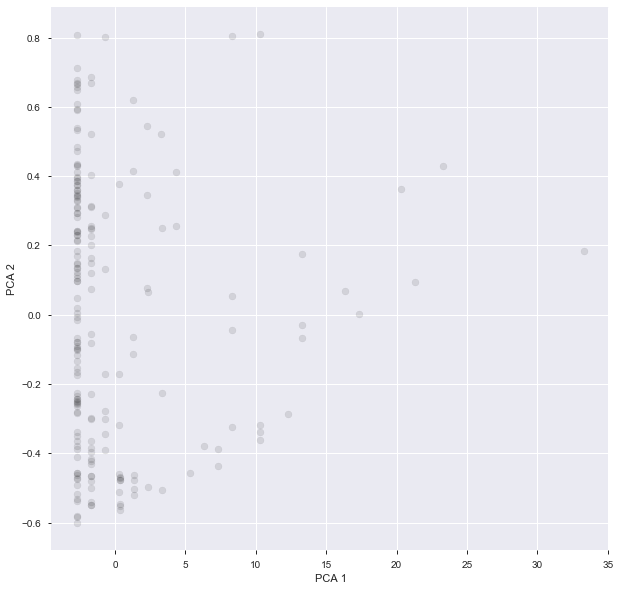

In [106]:
fig = plt.figure(figsize=(10,10))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

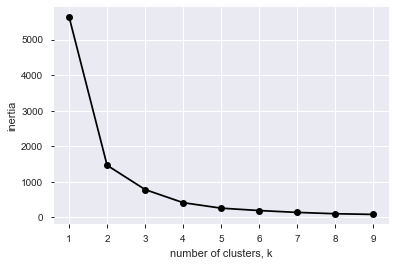

In [107]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [108]:
rr=KMeans(n_clusters=2).fit(acsg1)
rr.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

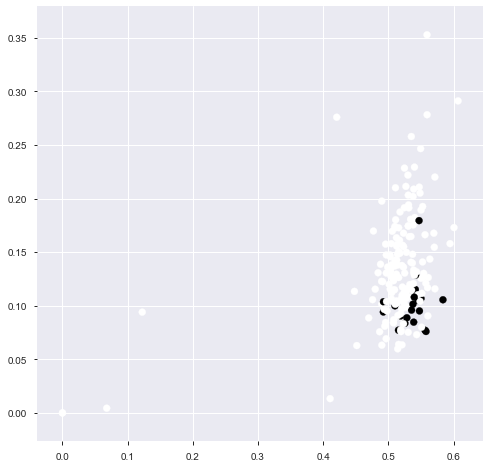

In [109]:
fig = plt.figure(figsize=(8,8))


plt.scatter(acsg1.iloc[:,0],acsg1.iloc[:,1],c=rr.labels_)

In [110]:
#Silhouette_score

X1=acsg1
range_n_clusters = [2, 3, 4, 5,6,7,8]
for n_clusters in range_n_clusters:
    km1 = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km1.fit_predict(X1)
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.817691093717729
For n_clusters = 3 The average silhouette_score is : 0.7651793527131202
For n_clusters = 4 The average silhouette_score is : 0.6798454477621558
For n_clusters = 5 The average silhouette_score is : 0.6801319149541022
For n_clusters = 6 The average silhouette_score is : 0.6753994779845567
For n_clusters = 7 The average silhouette_score is : 0.6156182752515148
For n_clusters = 8 The average silhouette_score is : 0.4722429114117978


In [142]:
acsg.head()

,Population,PopUnder18,PopOver65,MedianAge,PopHispanic,PopNotHisp,PopWhite,PopBlack,PopAsian,PopOTHER,Income0_49,Income_50_99,Income_100_199,Income_200up,EduOther,GardenCounts
GeogName,,,,,,,,,,,,,,,,
Bath Beach,33163.0,7103.0,4888.0,38.3,5861.0,27302.0,14490.0,404.0,11975.0,433.0,4953.0,3426.0,2464.0,585.0,14146.0,0
Bay Ridge,79134.0,15110.0,12380.0,39.5,14134.0,65000.0,50197.0,1511.0,11515.0,1777.0,13710.0,9678.0,7324.0,2775.0,27422.0,0
Bedford,75318.0,22379.0,5816.0,29.1,14682.0,60636.0,26407.0,30566.0,2290.0,1373.0,15008.0,5975.0,4042.0,1034.0,28145.0,23
Bensonhurst East,64267.0,12773.0,10107.0,39.6,7923.0,56344.0,29894.0,531.0,24858.0,1061.0,11327.0,6456.0,3560.0,844.0,28860.0,1
Bensonhurst West,91646.0,19288.0,13071.0,37.8,13378.0,78268.0,39112.0,801.0,37132.0,1223.0,14741.0,8545.0,5392.0,1231.0,43161.0,2


In [111]:
## STOPPED HERE DECEMBER 12data

#### Data set below contains garden count normalized

In [113]:
dec13= pd.read_csv('ACS_Merge_Norm_Final_lv.csv', index_col=0) 
dec13.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,Labor_forceN,CivilianLF,CLF_UnemployedN,PopOver25,EduOtherN,EduBachelor,EduGradProf,GardenCounts,HasGarden,GardenNorm
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,0.596016,15985,0.070566,23822,0.663798,0.224372,0.111829,0,0,0.000000
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,0.644115,42057,0.074922,58178,0.535735,0.271976,0.192289,0,0,0.000000
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,0.673776,36960,0.125027,44766,0.678193,0.204352,0.117455,23,1,0.043893
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,0.605483,31983,0.085202,46010,0.698153,0.204564,0.097283,1,1,0.001908
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,0.615577,45833,0.088342,65016,0.737618,0.188800,0.073582,2,1,0.003817


In [114]:
dec13.shape

(195, 40)

In [115]:
pandas_profiling.ProfileReport(dec13)

In [116]:
dec13.columns

Index(['GeoType', 'NTA', 'GeoID', 'Borough', 'Pop_1E', 'MaleEN', 'FemEN',
       'PopUnd18N', 'PopOv65N', 'HispN', 'NotHispN', 'WhiteN', 'BlackN',
       'NativeN', 'AsianN', 'PacificN', 'OtherRace1N', 'OtherRace2N', 'HHPop',
       'HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN', 'Pop16yrsOver', 'Labor_forceN',
       'CivilianLF', 'CLF_UnemployedN', 'PopOver25', 'EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts', 'HasGarden',
       'GardenNorm'],
      dtype='object')

In [117]:
#created income features by combining certain income variables:
dec13['Inc_low'] = dec13.HHINC_U10N + dec13.HHINC_10t14N + dec13.HHINC_15t24N + dec13.HHINC_25t34N + dec13.HHINC_35t49N 
dec13['Inc_mid'] = dec13.HHINC_50t74N + dec13.HHINC_75t99N
dec13['Inc_high'] = dec13.HHINC_100t149N + dec13.HHINC_150t199N + dec13.HHINC_200plN


In [118]:
dec13.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,PopOver25,EduOtherN,EduBachelor,EduGradProf,GardenCounts,HasGarden,GardenNorm,Inc_low,Inc_mid,Inc_high
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,23822,0.663798,0.224372,0.111829,0,0,0.000000,0.433409,0.299790,0.266801
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,58178,0.535735,0.271976,0.192289,0,0,0.000000,0.409413,0.289008,0.301580
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,44766,0.678193,0.204352,0.117455,23,1,0.043893,0.575924,0.229287,0.194789
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,46010,0.698153,0.204564,0.097283,1,1,0.001908,0.510524,0.290981,0.198495
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,65016,0.737618,0.188800,0.073582,2,1,0.003817,0.492862,0.285700,0.221438


In [157]:
dec13.columns

Index(['GeoType', 'NTA', 'GeoID', 'Borough', 'Pop_1E', 'MaleEN', 'FemEN',
       'PopUnd18N', 'PopOv65N', 'HispN', 'NotHispN', 'WhiteN', 'BlackN',
       'NativeN', 'AsianN', 'PacificN', 'OtherRace1N', 'OtherRace2N', 'HHPop',
       'HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN', 'Pop16yrsOver', 'Labor_forceN',
       'CivilianLF', 'CLF_UnemployedN', 'PopOver25', 'EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts', 'HasGarden', 'GardenNorm',
       'Inc_low', 'Inc_mid', 'Inc_high'],
      dtype='object')

In [132]:
#created new df w selected features for PCA:
dec13pca = dec13[['NTA','Labor_forceN','PopOv65N','HispN','WhiteN', 'BlackN','AsianN','Inc_low',
                  'Inc_mid','Inc_high','CLF_UnemployedN','EduOtherN',
       'EduBachelor', 'EduGradProf','GardenNorm']].copy()

In [135]:
dec13pca = dec13pca.set_index('NTA')

In [136]:
dec13pca.head()

,Labor_forceN,PopOv65N,HispN,WhiteN,BlackN,AsianN,Inc_low,Inc_mid,Inc_high,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenNorm
NTA,,,,,,,,,,,,,,
Bath Beach,0.596016,0.147393,0.176733,0.436933,0.012182,0.361095,0.433409,0.299790,0.266801,0.070566,0.663798,0.224372,0.111829,0.000000
Bay Ridge,0.644115,0.156444,0.178608,0.634329,0.019094,0.145513,0.409413,0.289008,0.301580,0.074922,0.535735,0.271976,0.192289,0.000000
Bedford,0.673776,0.077219,0.194933,0.350607,0.405826,0.030404,0.575924,0.229287,0.194789,0.125027,0.678193,0.204352,0.117455,0.043893
Bensonhurst East,0.605483,0.157266,0.123283,0.465153,0.008262,0.386793,0.510524,0.290981,0.198495,0.085202,0.698153,0.204564,0.097283,0.001908
Bensonhurst West,0.615577,0.142625,0.145975,0.426773,0.008740,0.405168,0.492862,0.285700,0.221438,0.088342,0.737618,0.188800,0.073582,0.003817


In [137]:
dec13pca.shape

(195, 14)

In [138]:
dec13pca = dec13pca.replace([np.inf, -np.inf, np.nan], 0)

In [139]:
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(dec13pca)

In [ ]:
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(dec13pca)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

fig = plt.figure(figsize=(10,10))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

([<matplotlib.axis.XTick at 0x1a23332940>,
 <a list of 10 Text xticklabel objects>)

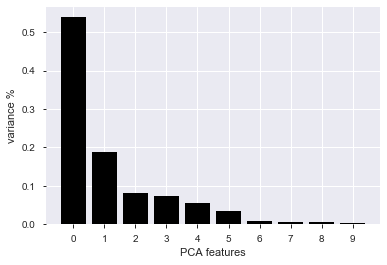

In [140]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [141]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

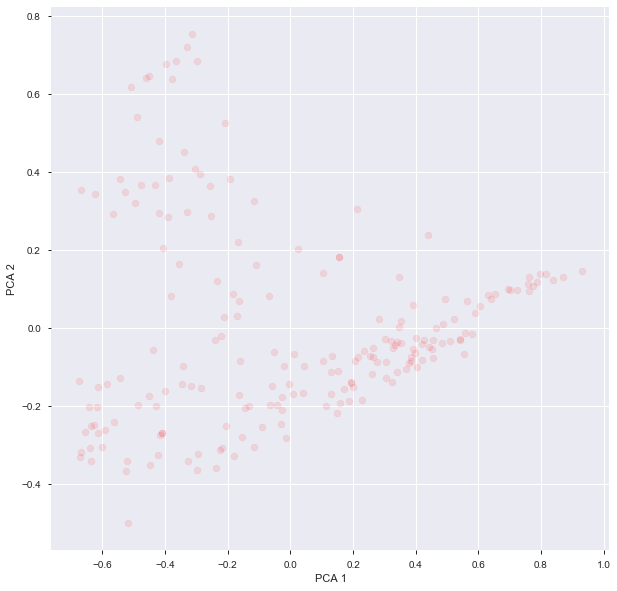

In [143]:
fig = plt.figure(figsize=(10,10))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

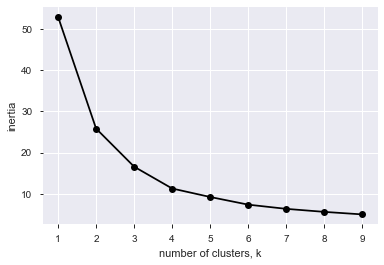

In [144]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [145]:
rr=KMeans(n_clusters=2).fit()
rr.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [155]:
rr=KMeans(n_clusters=3).fit(dec13pca)
rr.labels_

array([1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1,
       2, 2, 0, 0, 1, 1, 1, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1,
       1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 2,
       2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2],
      dtype=int32)

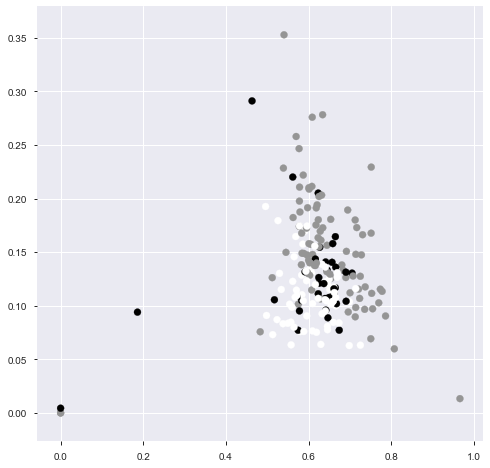

In [156]:
fig = plt.figure(figsize=(8,8))


plt.scatter(dec13pca.iloc[:,0],dec13pca.iloc[:,1],c=rr.labels_)

In [152]:
#Silhouette_score

X1=dec13pca
range_n_clusters = [2, 3, 4, 5,6,7,8]
for n_clusters in range_n_clusters:
    km1 = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km1.fit_predict(X1)
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.37413170473341467
For n_clusters = 3 The average silhouette_score is : 0.3799762237546839
For n_clusters = 4 The average silhouette_score is : 0.3391897172661313
For n_clusters = 5 The average silhouette_score is : 0.35792667481060964
For n_clusters = 6 The average silhouette_score is : 0.37807981914801986
For n_clusters = 7 The average silhouette_score is : 0.3653376223473595
For n_clusters = 8 The average silhouette_score is : 0.35107330851098884


#### Tried another combination of features for PCA round2 

In [ ]:
Index(['GeoType', 'NTA', 'GeoID', 'Borough', 'Pop_1E', 'MaleEN', 'FemEN',
       'PopUnd18N', 'PopOv65N', 'HispN', 'NotHispN', 'WhiteN', 'BlackN',
       'NativeN', 'AsianN', 'PacificN', 'OtherRace1N', 'OtherRace2N', 'HHPop',
       'HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN', 'Pop16yrsOver', 'Labor_forceN',
       'CivilianLF', 'CLF_UnemployedN', 'PopOver25', 'EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts', 'HasGarden', 'GardenNorm',
       'Inc_low', 'Inc_mid', 'Inc_high'],
      dtype='object')

In [160]:
dec13pca2 = dec13[['NTA','MaleEN', 'FemEN','HispN', 'WhiteN', 'BlackN','CLF_UnemployedN',
                  'EduOtherN','EduBachelor', 'EduGradProf','Inc_low', 'Inc_mid', 'Inc_high','GardenNorm']].copy()

In [162]:
dec13pca2 = dec13pca2.set_index('NTA')

In [164]:
dec13pca2.shape

(195, 13)

In [165]:
dec13pca2 = dec13pca2.replace([np.inf, -np.inf, np.nan], 0)

In [166]:
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(dec13pca2)

([<matplotlib.axis.XTick at 0x1a23cc1a20>,
 <a list of 10 Text xticklabel objects>)

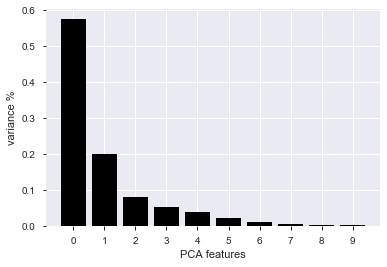

In [167]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [168]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

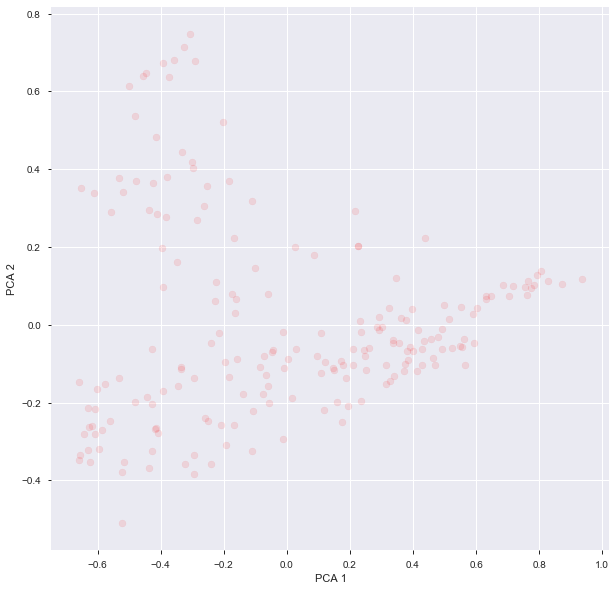

In [169]:
fig = plt.figure(figsize=(10,10))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

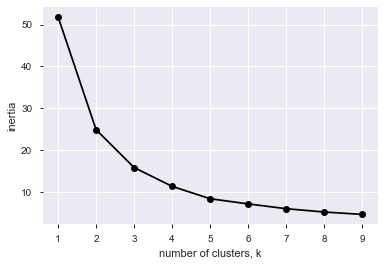

In [170]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [172]:
rr=KMeans(n_clusters=3).fit(dec13pca2)
rr.labels_

array([0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0,
       2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 0, 0,
       0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2,
       2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2],
      dtype=int32)

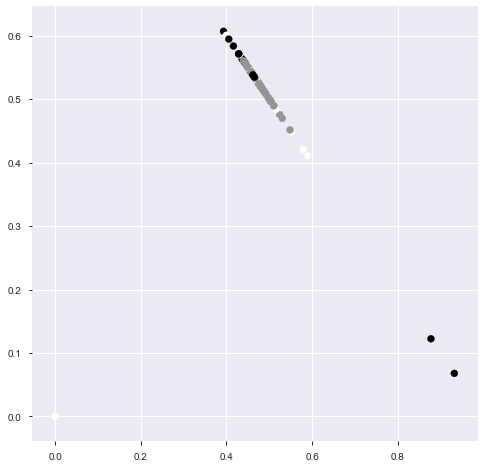

In [176]:
fig = plt.figure(figsize=(8,8))

plt.scatter(dec13pca2.iloc[:,0],dec13pca2.iloc[:,1],c=rr.labels_)

In [174]:
#Silhouette_score

X1=dec13pca2
range_n_clusters = [2, 3, 4, 5,6,7,8]
for n_clusters in range_n_clusters:
    km1 = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km1.fit_predict(X1)
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.3997700037164635
For n_clusters = 3 The average silhouette_score is : 0.4097672068006069
For n_clusters = 4 The average silhouette_score is : 0.3840022092859537
For n_clusters = 5 The average silhouette_score is : 0.36685901250734515
For n_clusters = 6 The average silhouette_score is : 0.37667871380782164
For n_clusters = 7 The average silhouette_score is : 0.3903789353490294
For n_clusters = 8 The average silhouette_score is : 0.3456272159449936


#### The version below incorporates crime data

In [178]:
dec13.columns

Index(['GeoType', 'NTA', 'GeoID', 'Borough', 'Pop_1E', 'MaleEN', 'FemEN',
       'PopUnd18N', 'PopOv65N', 'HispN', 'NotHispN', 'WhiteN', 'BlackN',
       'NativeN', 'AsianN', 'PacificN', 'OtherRace1N', 'OtherRace2N', 'HHPop',
       'HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN', 'Pop16yrsOver', 'Labor_forceN',
       'CivilianLF', 'CLF_UnemployedN', 'PopOver25', 'EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts', 'HasGarden', 'GardenNorm',
       'Inc_low', 'Inc_mid', 'Inc_high'],
      dtype='object')

In [179]:
dec13['Race_other'] = dec13.NativeN + dec13.PacificN + dec13.OtherRace1N + dec13.OtherRace2N

In [184]:
dec13.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,EduOtherN,EduBachelor,EduGradProf,GardenCounts,HasGarden,GardenNorm,Inc_low,Inc_mid,Inc_high,Race_other
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,0.663798,0.224372,0.111829,0,0,0.000000,0.433409,0.299790,0.266801,0.013057
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,0.535735,0.271976,0.192289,0,0,0.000000,0.409413,0.289008,0.301580,0.022456
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,0.678193,0.204352,0.117455,23,1,0.043893,0.575924,0.229287,0.194789,0.018229
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,0.698153,0.204564,0.097283,1,1,0.001908,0.510524,0.290981,0.198495,0.016509
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,0.737618,0.188800,0.073582,2,1,0.003817,0.492862,0.285700,0.221438,0.013345


In [186]:
dec13['Asian_other'] = dec13.Race_other + dec13.AsianN 

In [187]:
dec13.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,EduBachelor,EduGradProf,GardenCounts,HasGarden,GardenNorm,Inc_low,Inc_mid,Inc_high,Race_other,Asian_other
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,0.224372,0.111829,0,0,0.000000,0.433409,0.299790,0.266801,0.013057,0.374152
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,0.271976,0.192289,0,0,0.000000,0.409413,0.289008,0.301580,0.022456,0.167968
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,0.204352,0.117455,23,1,0.043893,0.575924,0.229287,0.194789,0.018229,0.048634
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,0.204564,0.097283,1,1,0.001908,0.510524,0.290981,0.198495,0.016509,0.403302
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,0.188800,0.073582,2,1,0.003817,0.492862,0.285700,0.221438,0.013345,0.418513


In [185]:
#loading crime data
crime = pd.read_csv('Crime_totals_normalized.csv', index_col=0) 
crime.head()


,FELONY,MISDEMEANOR,VIOLATION,TOTAL_CRIME,Population,GardenCounts,FELONY_norm,MISDEMEANOR_norm,VIOLATION_norm,TOTAL_CRIME_norm
ntaname,,,,,,,,,,
Allerton-Pelham Gardens,752.0,1925.0,444.0,3121.0,32450.0,1.0,0.023174,0.059322,0.013683,0.096179
Annadale-Huguenot-Prince's Bay-Eltingville,431.0,1215.0,464.0,2110.0,28698.0,0.0,0.015018,0.042337,0.016168,0.073524
Arden Heights,263.0,785.0,324.0,1372.0,26482.0,0.0,0.009931,0.029643,0.012235,0.051809
Astoria,4002.0,8082.0,2211.0,14295.0,77252.0,1.0,0.051804,0.104619,0.028621,0.185044
Auburndale,557.0,713.0,258.0,1528.0,20609.0,0.0,0.027027,0.034597,0.012519,0.074142


In [193]:
crime.shape

(192, 10)

In [188]:
dec13.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,EduBachelor,EduGradProf,GardenCounts,HasGarden,GardenNorm,Inc_low,Inc_mid,Inc_high,Race_other,Asian_other
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,0.224372,0.111829,0,0,0.000000,0.433409,0.299790,0.266801,0.013057,0.374152
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,0.271976,0.192289,0,0,0.000000,0.409413,0.289008,0.301580,0.022456,0.167968
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,0.204352,0.117455,23,1,0.043893,0.575924,0.229287,0.194789,0.018229,0.048634
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,0.204564,0.097283,1,1,0.001908,0.510524,0.290981,0.198495,0.016509,0.403302
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,0.188800,0.073582,2,1,0.003817,0.492862,0.285700,0.221438,0.013345,0.418513


In [189]:
dec13['ntaname'] = dec13['NTA']

In [190]:
dec13.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,EduGradProf,GardenCounts,HasGarden,GardenNorm,Inc_low,Inc_mid,Inc_high,Race_other,Asian_other,ntaname
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,0.111829,0,0,0.000000,0.433409,0.299790,0.266801,0.013057,0.374152,Bath Beach
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,0.192289,0,0,0.000000,0.409413,0.289008,0.301580,0.022456,0.167968,Bay Ridge
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,0.117455,23,1,0.043893,0.575924,0.229287,0.194789,0.018229,0.048634,Bedford
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,0.097283,1,1,0.001908,0.510524,0.290981,0.198495,0.016509,0.403302,Bensonhurst East
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,0.073582,2,1,0.003817,0.492862,0.285700,0.221438,0.013345,0.418513,Bensonhurst West


In [192]:
dec13.shape

(195, 46)

In [194]:
#merging ACS gardens + crime data
dec13c = dec13.merge(crime, how='left', left_on='ntaname', right_index=True, validate='one_to_one')
dec13c.shape

(195, 56)

In [195]:
dec13c.head()

,GeoType,NTA,GeoID,Borough,Pop_1E,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,...,FELONY,MISDEMEANOR,VIOLATION,TOTAL_CRIME,Population,GardenCounts_y,FELONY_norm,MISDEMEANOR_norm,VIOLATION_norm,TOTAL_CRIME_norm
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,0.503151,0.496849,0.214184,0.147393,0.176733,...,996.0,2177.0,479.0,3652.0,33163.0,0.0,0.030033,0.065645,0.014444,0.110123
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,0.478037,0.521963,0.190942,0.156444,0.178608,...,2661.0,6493.0,1886.0,11040.0,79134.0,0.0,0.033627,0.082051,0.023833,0.139510
2,NTA2010,Bedford,BK75,Brooklyn,75318,0.484492,0.515508,0.297127,0.077219,0.194933,...,6178.0,9390.0,2485.0,18053.0,75318.0,23.0,0.082026,0.124671,0.032993,0.239690
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,0.486766,0.513234,0.198749,0.157266,0.123283,...,1888.0,3085.0,962.0,5935.0,64267.0,1.0,0.029377,0.048003,0.014969,0.092349
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,0.487212,0.512788,0.210462,0.142625,0.145975,...,2539.0,4214.0,1201.0,7954.0,91646.0,2.0,0.027704,0.045981,0.013105,0.086790


In [197]:
dec13c.columns

Index(['GeoType', 'NTA', 'GeoID', 'Borough', 'Pop_1E', 'MaleEN', 'FemEN',
       'PopUnd18N', 'PopOv65N', 'HispN', 'NotHispN', 'WhiteN', 'BlackN',
       'NativeN', 'AsianN', 'PacificN', 'OtherRace1N', 'OtherRace2N', 'HHPop',
       'HHINC_U10N', 'HHINC_10t14N', 'HHINC_15t24N', 'HHINC_25t34N',
       'HHINC_35t49N', 'HHINC_50t74N', 'HHINC_75t99N', 'HHINC_100t149N',
       'HHINC_150t199N', 'HHINC_200plN', 'Pop16yrsOver', 'Labor_forceN',
       'CivilianLF', 'CLF_UnemployedN', 'PopOver25', 'EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenCounts_x', 'HasGarden',
       'GardenNorm', 'Inc_low', 'Inc_mid', 'Inc_high', 'Race_other',
       'Asian_other', 'ntaname', 'FELONY', 'MISDEMEANOR', 'VIOLATION',
       'TOTAL_CRIME', 'Population', 'GardenCounts_y', 'FELONY_norm',
       'MISDEMEANOR_norm', 'VIOLATION_norm', 'TOTAL_CRIME_norm'],
      dtype='object')

In [222]:
#new dataframe combining selected ACS features + garden data normalized + crime 
acscrime = dec13c[['NTA','PopOv65N','HispN','WhiteN', 'BlackN',
           'CLF_UnemployedN','EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenNorm','Inc_low', 'Inc_mid', 'Inc_high',
           'FELONY_norm',
       'MISDEMEANOR_norm', 'VIOLATION_norm' ]].copy()

In [223]:
acscrime.head()

,NTA,PopOv65N,HispN,WhiteN,BlackN,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenNorm,Inc_low,Inc_mid,Inc_high,FELONY_norm,MISDEMEANOR_norm,VIOLATION_norm
0,Bath Beach,0.147393,0.176733,0.436933,0.012182,0.070566,0.663798,0.224372,0.111829,0.000000,0.433409,0.299790,0.266801,0.030033,0.065645,0.014444
1,Bay Ridge,0.156444,0.178608,0.634329,0.019094,0.074922,0.535735,0.271976,0.192289,0.000000,0.409413,0.289008,0.301580,0.033627,0.082051,0.023833
2,Bedford,0.077219,0.194933,0.350607,0.405826,0.125027,0.678193,0.204352,0.117455,0.043893,0.575924,0.229287,0.194789,0.082026,0.124671,0.032993
3,Bensonhurst East,0.157266,0.123283,0.465153,0.008262,0.085202,0.698153,0.204564,0.097283,0.001908,0.510524,0.290981,0.198495,0.029377,0.048003,0.014969
4,Bensonhurst West,0.142625,0.145975,0.426773,0.008740,0.088342,0.737618,0.188800,0.073582,0.003817,0.492862,0.285700,0.221438,0.027704,0.045981,0.013105


In [226]:
acscrime = acscrime.set_index('NTA')

In [227]:
acscrime = acscrime.replace([np.inf, -np.inf, np.nan], 0)

In [228]:
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(acscrime)

([<matplotlib.axis.XTick at 0x1a1e96de48>,
 <a list of 10 Text xticklabel objects>)

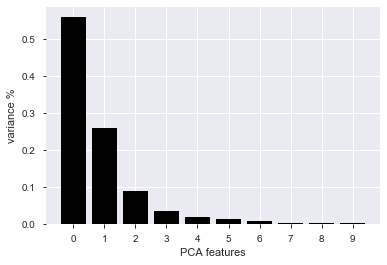

In [229]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


In [230]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)


Text(0, 0.5, 'PCA 2')

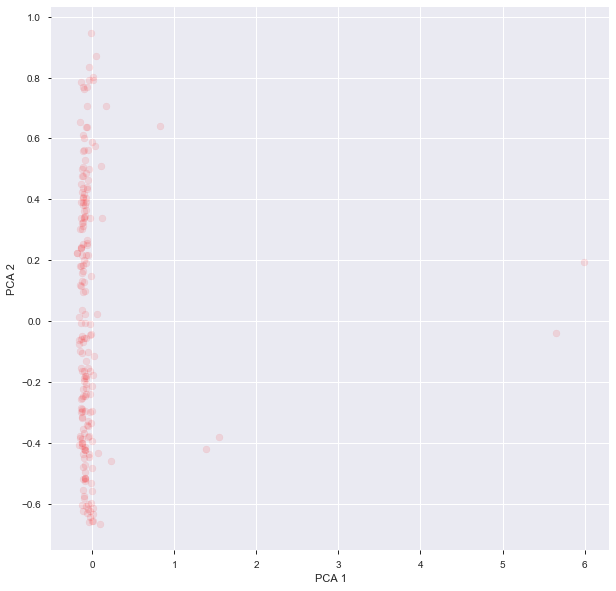

In [231]:
fig = plt.figure(figsize=(10,10))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

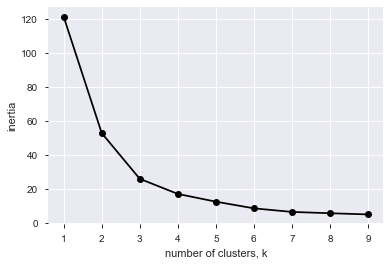

In [232]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [233]:
rr=KMeans(n_clusters=2).fit(acscrime)
rr.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

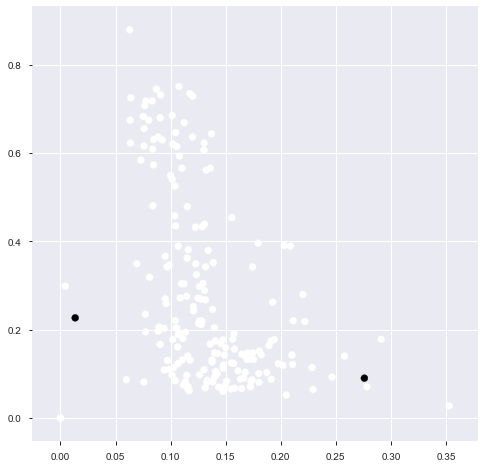

In [234]:
fig = plt.figure(figsize=(8,8))

plt.scatter(acscrime.iloc[:,0],acscrime.iloc[:,1],c=rr.labels_)

In [235]:
#Silhouette_score

X1=acscrime
range_n_clusters = [2, 3, 4, 5,6,7,8]
for n_clusters in range_n_clusters:
    km1 = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km1.fit_predict(X1)
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.8737300128701443
For n_clusters = 3 The average silhouette_score is : 0.38932989917460076
For n_clusters = 4 The average silhouette_score is : 0.39977153421457157
For n_clusters = 5 The average silhouette_score is : 0.37011911949993426
For n_clusters = 6 The average silhouette_score is : 0.38377618537193325
For n_clusters = 7 The average silhouette_score is : 0.36885798653805735
For n_clusters = 8 The average silhouette_score is : 0.3784839098561597


#### Tried another combination of acs + garden + crime data

In [236]:
acscrime1 = dec13c[['NTA','HispN','WhiteN', 'BlackN',
           'CLF_UnemployedN','EduOtherN',
       'EduBachelor', 'EduGradProf', 'GardenNorm','Inc_low', 'Inc_mid', 'Inc_high',
           'FELONY_norm',
       'MISDEMEANOR_norm', 'VIOLATION_norm' ]].copy()

In [238]:
acscrime1.head()

,NTA,HispN,WhiteN,BlackN,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenNorm,Inc_low,Inc_mid,Inc_high,FELONY_norm,MISDEMEANOR_norm,VIOLATION_norm
0,Bath Beach,0.176733,0.436933,0.012182,0.070566,0.663798,0.224372,0.111829,0.000000,0.433409,0.299790,0.266801,0.030033,0.065645,0.014444
1,Bay Ridge,0.178608,0.634329,0.019094,0.074922,0.535735,0.271976,0.192289,0.000000,0.409413,0.289008,0.301580,0.033627,0.082051,0.023833
2,Bedford,0.194933,0.350607,0.405826,0.125027,0.678193,0.204352,0.117455,0.043893,0.575924,0.229287,0.194789,0.082026,0.124671,0.032993
3,Bensonhurst East,0.123283,0.465153,0.008262,0.085202,0.698153,0.204564,0.097283,0.001908,0.510524,0.290981,0.198495,0.029377,0.048003,0.014969
4,Bensonhurst West,0.145975,0.426773,0.008740,0.088342,0.737618,0.188800,0.073582,0.003817,0.492862,0.285700,0.221438,0.027704,0.045981,0.013105


In [239]:
acscrime1 = acscrime1.set_index('NTA')

In [242]:
acscrime1 = acscrime1.replace([np.inf, -np.inf, np.nan], 0)

In [243]:
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(acscrime1)

([<matplotlib.axis.XTick at 0x1a1e960860>,
 <a list of 10 Text xticklabel objects>)

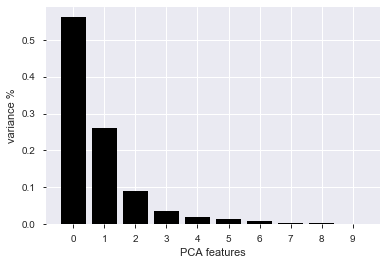

In [244]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [245]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

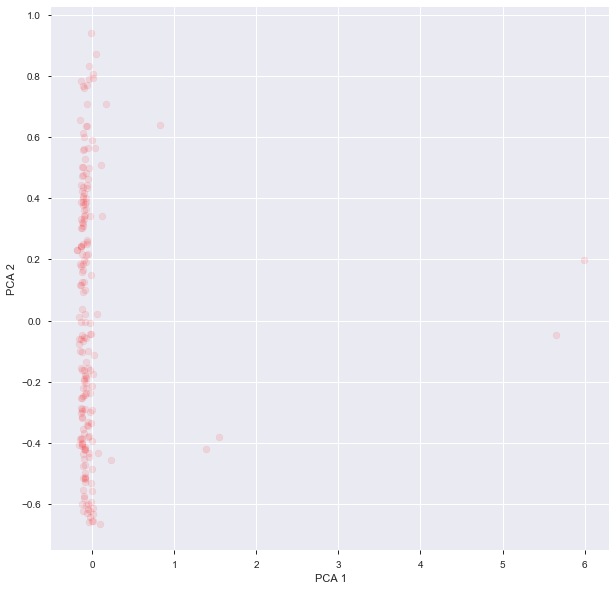

In [246]:
fig = plt.figure(figsize=(10,10))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

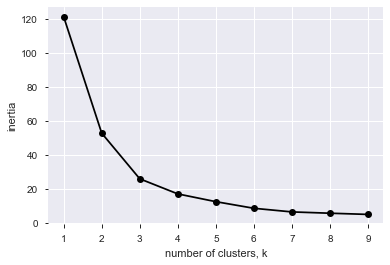

In [247]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [253]:
rr=KMeans(n_clusters=2).fit(acscrime1)
rr.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

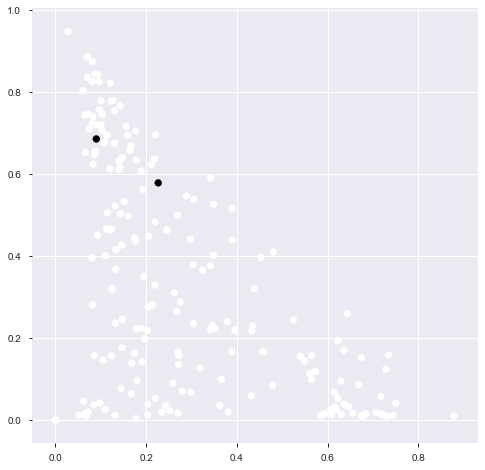

In [254]:
fig = plt.figure(figsize=(8,8))

plt.scatter(acscrime1.iloc[:,0],acscrime1.iloc[:,1],c=rr.labels_)

In [255]:
#Silhouette_score

X1=acscrime1
range_n_clusters = [2, 3, 4, 5,6,7,8]
for n_clusters in range_n_clusters:
    km1 = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km1.fit_predict(X1)
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.8743162448498704
For n_clusters = 3 The average silhouette_score is : 0.391577350318352
For n_clusters = 4 The average silhouette_score is : 0.4028706370257255
For n_clusters = 5 The average silhouette_score is : 0.41164602121176136
For n_clusters = 6 The average silhouette_score is : 0.3862189515686265
For n_clusters = 7 The average silhouette_score is : 0.37304232547603433
For n_clusters = 8 The average silhouette_score is : 0.3828071750672401


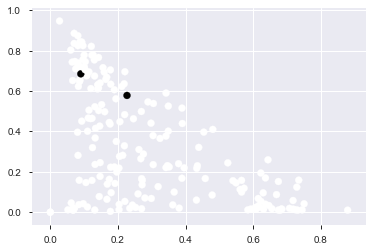

In [272]:
#trying gaussian & dbscan but not sure if correct
gmm = GMM(n_components=3).fit(acscrime1)
labels = gmm.predict(acscrime1)
plt.scatter(acscrime1.iloc[:,0],acscrime1.iloc[:,1],c=rr.labels_)

In [260]:

from sklearn.mixture import GaussianMixture as GMM # You can import this only if you are using 0.18+ sklearn.
##gm=GaussianMixture(n_components=2,random_state=324)
#res1=gm.fit(np.array([x,y]).transpose())

In [264]:

from sklearn.cluster import DBSCAN

In [269]:
res2 = DBSCAN(eps=0.1, min_samples=3).fit(acscrime1)
L2=res2.labels_

Text(0, 0.5, 'X2')

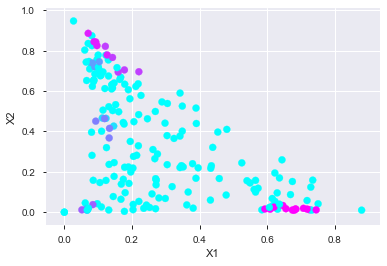

In [270]:
plt.scatter(acscrime1.iloc[:,0],acscrime1.iloc[:,1], c=L2, cmap=plt.cm.cool)
plt.xlabel('X1')
plt.ylabel('X2')